# Grab data

In [1]:
from herbie import Herbie, wgrib2, paint
from pathlib import Path
import pandas as pd

import xarray as xr
from herbie.toolbox import EasyMap, ccrs, pc

In [2]:
# grab palisades data for smoke
H = Herbie(
    "2025-01-10",
    model="hrrr",
    product="sfc",
    fxx=0,
)

H.download("MASSDEN")

my_file = H.get_localFilePath("MASSDEN")

my_file, my_file.exists()

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


(PosixPath('/home/mgraca/data/hrrr/20250110/subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2'),
 True)

# Use `wgrib` wrapper to subregion the data
While you can download a subset of the data by feature, there is no method in which you can download a subregion. You'll have to first download the subset of features you want, THEN create the subregion. `wgrib2` is a tool created by NOAA self-described as a "tool to read and write grib files"
- https://www.cpc.ncep.noaa.gov/products/wesley/wgrib2/

Herbie doesn't natively support the ability to subregion data, so the authors instead provide a wrapper for this tool; this does mean that you'll have to download `wgrib2` separately. But thankfully, both `herbie` and `wgrib2` can be cleanly downloaded via `conda`.

In [3]:
# Print the standard inventory of a grib2 file
print(wgrib2.inventory(my_file))

1:0:d=2025011000:MASSDEN:8 m above ground:anl:



In [4]:
# Create a standard inventory file

idx_file = wgrib2.create_inventory_file(my_file)

idx_file, idx_file.exists()

(PosixPath('/home/mgraca/data/hrrr/20250110/subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.idx'),
 True)

In [5]:
wgrib2.vector_relative(my_file)

All winds are grid-relative winds.


{'winds(grid)'}

In [6]:
# Create a regional subset of the file
lat_bottom, lat_top = 33.28, 34.86
lon_bottom, lon_top = -119.1, -117.3

extent = (lon_bottom, lon_top, lat_bottom, lat_top)

subset_file = wgrib2.region(my_file, extent, name="la_region")
subset_file

PosixPath('/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2')

In [7]:
# Look at the inventory file again to see it is different 
# from before the region subset
pd.read_csv(str(subset_file) + ".idx", delimiter=":", header=None)

,0,1,2,3,4,5,6
0,1,0,d=2025011000,MASSDEN,8 m above ground,anl,NaN


In [8]:
my_file, subset_file

(PosixPath('/home/mgraca/data/hrrr/20250110/subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2'),
 PosixPath('/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2'))

# Convert to `xarray` and visualize subregion

## `xarray` conversion

In [9]:
# Get crs from a regular Herbie object
ds = H.xarray("MASSDEN")
crs = ds.herbie.crs

# (can't use Herbie to open FILE yet, so just use xarray)
ds_region = xr.open_dataset(subset_file, engine="cfgrib")

/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/herbie/core.py:1106: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTime

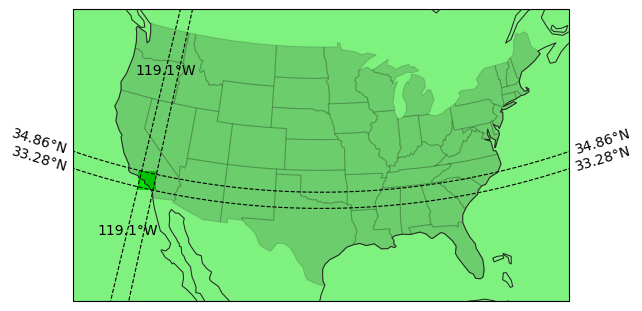

In [21]:
ax = EasyMap(crs=crs).STATES(color="k").ax
ax.pcolormesh(ds.longitude, ds.latitude, ds.mdens, alpha=0.5, transform=pc, **paint.AQIPm25.kwargs2)
ax.pcolormesh(ds_region.longitude, ds_region.latitude, ds_region.mdens, transform=pc, **paint.AQIPm25.kwargs2)

ax.gridlines(xlocs=extent[:2], ylocs=extent[2:], color="k", ls="--", draw_labels=True)

In [11]:
ds

<xarray.Dataset> Size: 38MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2025-01-10
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 8.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B ...
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    mdens                (y, x) float32 8MB 1.52e-09 1.52e-09 ... 8.855e-26
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/mgraca/data/hrrr/20250110/subset_d9ef9dd4_...
    search:                  MASSDEN

In [12]:
ds_region

<xarray.Dataset> Size: 92kB
Dimensions:            (y: 69, x: 67)
Coordinates:
    time               datetime64[ns] 8B ...
    step               timedelta64[ns] 8B ...
    heightAboveGround  float64 8B ...
    latitude           (y, x) float64 37kB 32.97 32.98 32.99 ... 35.15 35.15
    longitude          (y, x) float64 37kB 241.0 241.0 241.1 ... 242.6 242.6
    valid_time         datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    mdens              (y, x) float32 18kB 1.6e-10 1.6e-10 ... 8.855e-26
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-03-21T18:32 GRIB to CDM+CF via cfgrib-0.9.1...

In [13]:
ds_region['mdens']

<xarray.DataArray 'mdens' (y: 69, x: 67)> Size: 18kB
array([[1.60000e-10, 1.60000e-10, 1.60000e-10, ..., 2.40000e-10, 8.85486e-26,
        8.85486e-26],
       [1.60000e-10, 1.60000e-10, 1.60000e-10, ..., 8.00000e-11, 8.85486e-26,
        8.85486e-26],
       [1.60000e-10, 1.60000e-10, 1.60000e-10, ..., 8.85486e-26, 8.85486e-26,
        8.85486e-26],
       ...,
       [8.00000e-11, 8.00000e-11, 1.60000e-10, ..., 8.85486e-26, 8.85486e-26,
        8.85486e-26],
       [1.60000e-10, 1.60000e-10, 2.40000e-10, ..., 8.85486e-26, 8.85486e-26,
        8.85486e-26],
       [4.00000e-10, 3.20000e-10, 3.20000e-10, ..., 8.85486e-26, 8.85486e-26,
        8.85486e-26]], shape=(69, 67), dtype=float32)
Coordinates:
    time               datetime64[ns] 8B ...
    step               timedelta64[ns] 8B ...
    heightAboveGround  float64 8B ...
    latitude           (y, x) float64 37kB 32.97 32.98 32.99 ... 35.15 35.15
    longitude          (y, x) float64 37kB 241.0 241.0 241.1 ... 242.6 242.6
    valid_time         datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Attributes: (12/34)
    GRIB_paramId:                             400000
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      4623
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                Mass density
    GRIB_shortName:                           mdens
    GRIB_units:                               kg m**-3
    long_name:                                Mass density
    units:                                    kg m**-3
    standard_name:                            unknown

## Visualizing
1. Built-in plot function
2. to Plate Carree
3. to Lambert Conical Conformal
4. to Robinson

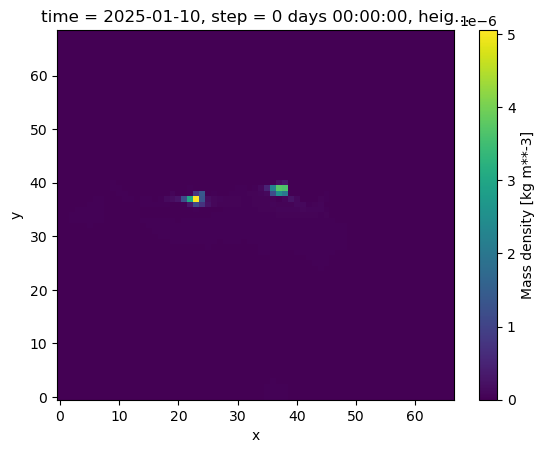

In [14]:
ds_region['mdens'].plot()

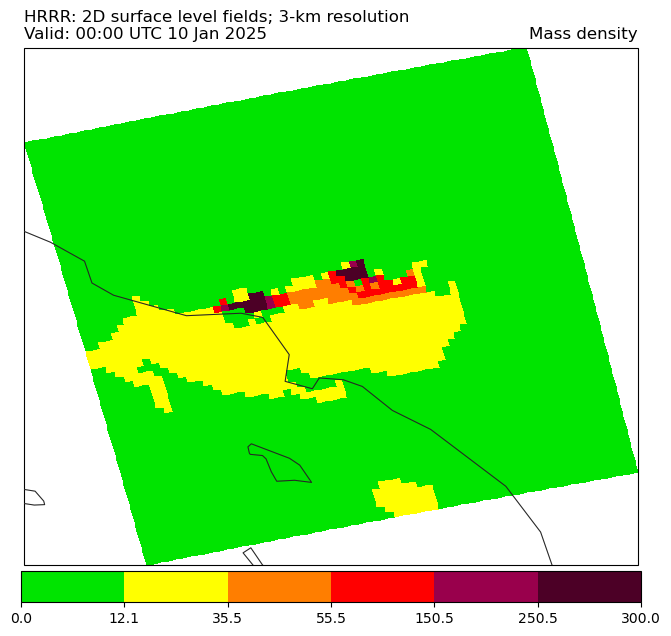

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
from herbie.toolbox import EasyMap, pc, ccrs
from herbie import paint

def plot(ds, coords=None, save=False, proj=pc):
    micro_per_k = 1000000000

    plt.figure()
    ax = EasyMap("50m", crs=proj, figsize=[10, 8]).BORDERS().STATES().ax
    
    if coords != None:
        ax.set_extent(coords)
    
    p = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.mdens * micro_per_k,
        transform=pc,
        **paint.AQIPm25.kwargs2,
    )
    plt.colorbar(
        p,
        ax=ax,
        orientation="horizontal",
        pad=0.01,
        shrink=0.8,
        **paint.AQIPm25.kwargs2,
    )
    
    ax.set_title(
        f"HRRR: {H.product_description}\nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
        loc="left",
    )
    ax.set_title(ds.mdens.GRIB_name, loc="right")

    if save:
        plt.savefig(f"images/hrrr_viz_{str(int(ds.step.item() / 3600000000000)).zfill(2)}.png")
        
    plt.show()
    plt.clf()

plot(ds_region)

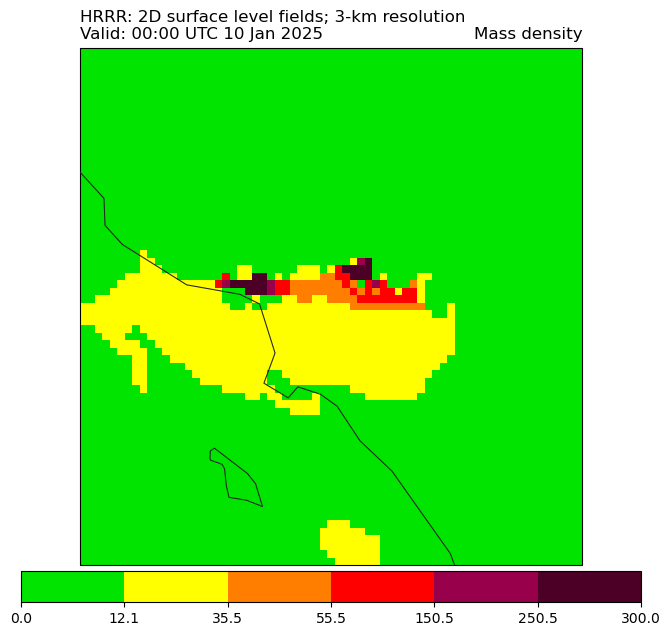

<Figure size 640x480 with 0 Axes>

In [16]:
plot(ds_region, proj=ds.herbie.crs)

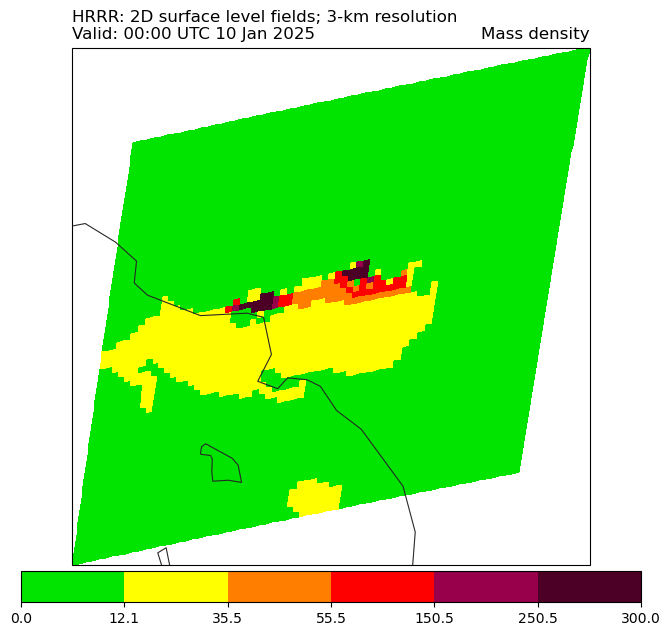

<Figure size 640x480 with 0 Axes>

In [17]:
plot(ds_region, proj=ccrs.Robinson())

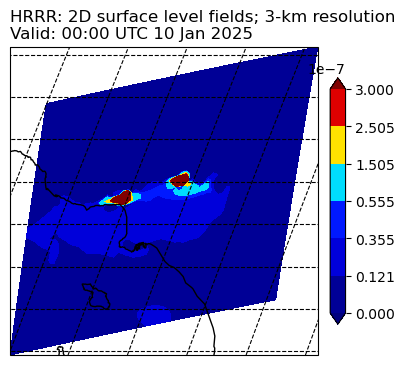

In [18]:
import numpy as np

# attempting to look the same as the pwwb notebook
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m",linewidth=1)
ax.gridlines(linestyle='--',color='black')

# Set contour levels, then draw the plot and a colorbar
clevs = [a / 1000000000 for a in [0, 12.1, 35.5, 55.5, 150.5, 250.5, 300]]
clevs = np.array(np.array(clevs))
plt.contourf(ds_region.longitude, ds_region.latitude, ds_region.mdens, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet,extend="both")
#plt.title(sub_ds.mdens.GRIB_name, size=14)
ax.set_title(
    f"HRRR: {H.product_description}\nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
#ax.set_title(ds.mdens.GRIB_name, loc="right")
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.ax.tick_params(labelsize=10)

## Thoughts relative to the previous notebook (manual method)
I believe is should be more correct than the manual method I've run in the previous notebook. 

First, I trust a NOAA-developed utility specially designed for grib files than my own code. 

Secondly, the projections on the map seem to make more sense; compare these images to the previous notebook, the way the projections are stretched makes more sense here. 

The logic here is for LCC to Plate Carree, the data bends up like a rainbow; meaning that a subregion on the bottom left of the map should be a diamond, from bottom left to upper right. The image in this notebook is in line with my expectations, while the image in the previous notebook is not.

Meanwhile, for the native LCC projection, the image should definitely be just a square, but that's not the case in the previous notebook.

There is one downside, and that is some attributes are stripped during the subregion phase, because the result is an `xarray` object and not a `Herbie` object; for example, attributes like
```
institution : US National Weather Service - NCEP
model : hrrr
product : sfc
description : High-Resolution Rapid Refresh - CONUS
```
were stripped. This is remedied by keeping the reference to the original datasets pulled by Herbie if you want to refer to such attributes.

Finally, no NaNs are in the array, meaning we don't need to perform any imputation.

In [19]:
# xarray has a simple to_numpy() method; just specify the feature.
ds_region['mdens'].to_numpy()

array([[1.60000e-10, 1.60000e-10, 1.60000e-10, ..., 2.40000e-10,
        8.85486e-26, 8.85486e-26],
       [1.60000e-10, 1.60000e-10, 1.60000e-10, ..., 8.00000e-11,
        8.85486e-26, 8.85486e-26],
       [1.60000e-10, 1.60000e-10, 1.60000e-10, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26],
       ...,
       [8.00000e-11, 8.00000e-11, 1.60000e-10, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26],
       [1.60000e-10, 1.60000e-10, 2.40000e-10, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26],
       [4.00000e-10, 3.20000e-10, 3.20000e-10, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26]], shape=(69, 67), dtype=float32)

# Conversion to numpy and channel for the ConvLSTM
Now that we know we have a validated region, let's try to fit this to our purposes by describing the entire pipeline:
1. Download the 12 hour forecast for the Palisades fire
2. Use `herbie`'s `wgrib2` wrapper to subregion the data to the LA metropolitan area
3. Convert data to numpy
4. Interpolate to fit dimensions (40 x 40 or 200 x 200?)
5. Expand to 5D tensor (samples, frames, rows, columns, filters)

# Conclusions
- Herbie's wrapper for the `wgrib2` utility is used for all things grib; in this case, creating a subregion of the grib data.
- This method is likely more correct than the manual subsetting method, based on what the projections look like.
- This method also does not produce NaNs, providing a proper subset of the data; meaning no imputation is required.